In [1]:
# Parametric Changes

# Activation function => ConvLSTM2D = tanh/ReLU; Dense = SoftMAx/Tanh/Sparsemax
# convLSTM Model => Flatten() / Global_average_pooling()


In [2]:
# Importing Library


import os
import sys                                          #size of a variabal
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [3]:
my_variable="s.mp4"
size=sys.getsizeof(my_variable)
print(f"the size of the variable is {size} bytes.")

the size of the variable is 54 bytes.


In [4]:
# connect to the drive
from google.colab import drive
# drive path
drive.mount('/content/drive/',force_remount=True)
os.listdir('/content/drive/MyDrive')

Mounted at /content/drive/


['The_Omniscient_App',
 'Python_ML_Model',
 'Colab_Notebooks',
 'CCTV_Electronics_Part',
 'Colab Notebooks']

In [5]:
# Seed Constants for model stable results

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:

# Data Preprocessing

# Specify the height and width of video frames
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/drive/MyDrive/Python_ML_Model/Datasets"

if os.path.exists(DATASET_DIR):
    print("File exists!")

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =["smoke","shoot_gun","run","hit"]


# Frame Extraction From video


def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list



# Dataset Creation Function



def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        i = 0
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            i = i+1
            if(i==10):
              print("break",i)
              i = 0
              break
            else:
              print("inserted",i)
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

# Create the dataset.
features, labels, video_files_paths = create_dataset()

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

File exists!
Extracting Data of Class: smoke
inserted 1
inserted 2
inserted 3
inserted 4
inserted 5
inserted 6
inserted 7
inserted 8
inserted 9
break 10
Extracting Data of Class: shoot_gun
inserted 1
inserted 2
inserted 3
inserted 4
inserted 5
inserted 6
inserted 7
inserted 8
inserted 9
break 10
Extracting Data of Class: run
inserted 1
inserted 2
inserted 3
inserted 4
inserted 5
inserted 6
inserted 7
inserted 8
inserted 9
break 10
Extracting Data of Class: hit
inserted 1
inserted 2
inserted 3
inserted 4
inserted 5
inserted 6
inserted 7
inserted 8
inserted 9
break 10


In [7]:
# Spliting the dataset into Training and test set

# Split the Data into Training ( 75% ) and Testing Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.25, shuffle=True,random_state=seed_constant)


In [8]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.4)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.4)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [9]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

In [10]:
# Compile & Train the Model

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
6/6 [==============================] - 29s 769ms/step - loss: 1.4033 - accuracy: 0.1905 - val_loss: 1.3969 - val_accuracy: 0.1667
Epoch 2/50
6/6 [==============================] - 5s 892ms/step - loss: 1.3686 - accuracy: 0.2381 - val_loss: 1.4597 - val_accuracy: 0.1667
Epoch 3/50
6/6 [==============================] - 4s 746ms/step - loss: 1.3032 - accuracy: 0.3810 - val_loss: 1.7094 - val_accuracy: 0.1667
Epoch 4/50
6/6 [==============================] - 3s 491ms/step - loss: 1.3529 - accuracy: 0.3333 - val_loss: 1.6310 - val_accuracy: 0.1667
Epoch 5/50
6/6 [==============================] - 3s 469ms/step - loss: 1.3159 - accuracy: 0.3333 - val_loss: 1.5095 - val_accuracy: 0.1667
Epoch 6/50
6/6 [==============================] - 3s 472ms/step - loss: 1.2980 - accuracy: 0.3333 - val_loss: 1.5092 - val_accuracy: 0.1667
Epoch 7/50
6/6 [==============================] - 3s 575ms/step - loss: 1.2862 - accuracy: 0.3810 - val_loss: 1.5067 - val_accuracy: 0.1667
Epoch 8/50
6/6 [===

In [11]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 0s 382ms/step - loss: 1.7778 - accuracy: 0.1111


In [12]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'/content/drive/MyDrive/Python_ML_Model/results/convlstm_model_{current_date_time_string}__Loss__{model_evaluation_loss}__Accuracy__{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



Plot Model’s Loss & Accuracy Curves

In [13]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

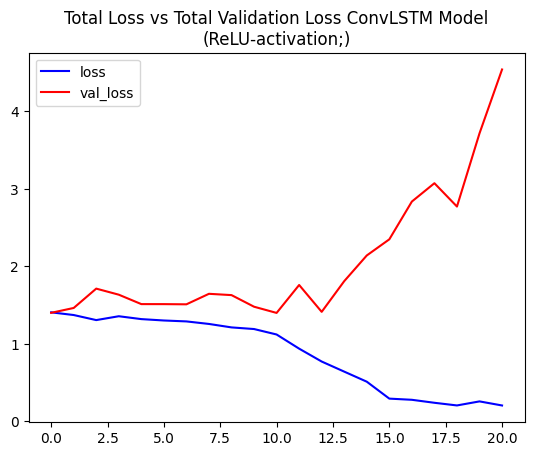

In [14]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss ConvLSTM Model\n(ReLU-activation;)')

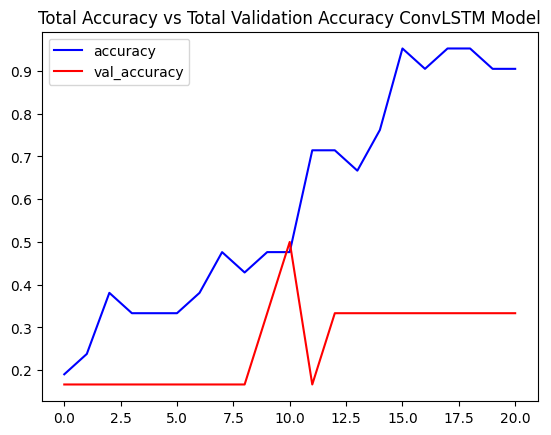

In [15]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy ConvLSTM Model')

In [16]:
# Function ot performactoin recognisation on video


def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the ConvLSTM model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [17]:

# Construct the output video path.
output_video_file_path = f'/content/drive/MyDrive/Python_ML_Model/temp_2.mp4'
# Perform Action Recognition on the Test Video.
predict_on_video('/content/drive/MyDrive/Python_ML_Model/s.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 55ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [18]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive

drive.mount('/content/drive/')


IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
CLASSES_LIST =["smoke","shoot_gun","run","hit"]


convlstm_model_h5 = load_model('/content/drive/MyDrive/Python_ML_Model/results/convlstm_model.h5')


def predict_single_action(video_file_path,output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the ConvLSTM model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()
        video_writer.write(frame)
        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model_h5.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    # Release the VideoCapture object.
    video_reader.release()
    video_writer.release()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
#  # Construct tihe input youtube video path
output_video_file_path = f'/content/drive/MyDrive/Python_ML_Model/temp_2.mp4'

#  # Perform Single Prediction on the Test Video.
predict_single_action('/content/drive/MyDrive/Python_ML_Model/s.mp4', output_video_file_path ,SEQUENCE_LENGTH)

#  # Display the input video.
#  VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 1s 762ms/step
Action Predicted: shoot_gun
Confidence: 0.9998883008956909
